# A Pythonic Approach to LabOne

When looking up what does Python stand for, keywords such as readability, easy-to-use, and elegant syntax will quickly pop-up - even though, depending on your background, you may see room for discussion here. “Pythonic” code follows the common guidelines and makes use of Python’s language features to produce readable and maintainable code. Compared to LabOne®’s native Python API, ziPython, you might notice some contradictions which originate from a sensible background.

In this blog post, we intend to shed light on zhinst-toolkit, our all-new high-level API, and point out why it is not meant to replace ziPython but rather to improve its user experience.

## LabOne Background

Test and measurement instruments from Zurich Instruments follow the concept where one software suite, LabOne, enables instrument control, signal acquisition, data analysis and storage. Besides its web-based graphical user interface (GUI), LabOne also comes with application programming interfaces (APIs) for C, Python, .NET, MATLAB, and LabVIEW.

To guarantee the required performance and stability across the whole LabOne software stack, all LabOne APIs, including its web-based user interface, are built upon the same underlying shared codebase. This architecture has numerous benefits. Among others, it allows us to optimize performance-sensitive code paths and guarantee the same general behavior for all our APIs. Nevertheless, it comes with the cost - different APIs are not optimally embedded into their respective programming language.

Since the Python language is becoming more and more important in the scientific world, especially in the quantum area, we wanted to provide a modernized Python API with great user experience, allowing our users to implement complex experiments involving multiple instruments from various vendors. This is exactly where zhinst-toolkit, a high-level Python API wrapping around ziPython, comes into play. It is now easy to understand the differences between these two Python APIs. ziPython remains the low-level LabOne API, implemented in C++, optimized for speed, and exposing the LabOne structure. Whereas the zhinst-toolkit is a pure Python-based, open-source wrapper around the LabOne Python API.

Since zhinst-toolkit is only a wrapper around ziPython, one can do nearly everything that can be done with ziPython using the toolkit with minimal performance loss. As the last resort, one can always access the underlying ziPython objects through zhinst-toolkit when necessary.

​
## Introduction to zhinst-toolkit

In this section, we demonstrate how to use the zhinst-toolkit package to control an instrument, carry out measurement and acquire signals. This requires the following steps:

Establish a connection between instrument and client.
Adjust the instrument settings according to measurement requirements.
Acquire the measured signal for subsequent post-processing.
The zhinst-toolkit is available in PyPI and the source files are available on GitHub. We welcome community contributions. It can be simply installed by the following command:

```
pip install zhinst-toolkit
```

### Connecting to the instrument

The entry point into LabOne is a session to its Data Server. LabOne supports two data servers: one for HF2LI and one for all other instruments. The Session class is responsible for opening a connection from the client side to the data server as shown in the following code snippet:

In [1]:
from zhinst.toolkit import Session

# IP address of the host computer where the Data Servers run
server_host = 'localhost'
# A session opened to LabOne Data Server
session = Session(server_host)
# A session opened to HF2 Data Server
hf2_session = Session(server_host, hf2=True)

By default, LabOne data servers listen to ports 8005 for HF2LI, and 8004 for all other instruments. However, one can change the port when instantiating the corresponding data server. For the HF2 platform as a special case, a flag needs to be set during the creation of the API session as shown in the above snippet. Apart from that, everything else can be applied to HF2LI the same way as to other platforms.

The next step is to connect your device(s) to the Data Server. This requires the serial number(s) of the involved instrument(s):

In [1]:
device = session.connect_device("DEV2345")

### Modifying the device settings

The Data Server organizes the data and settings in a hierarchical structure called the node tree. The measured signals and device settings are represented by leaves in the node tree. Using zhinst-toolkit one can access the nodes through attributes/items. If supported by the editor, Auto/Tab Completion is available to browse through the node tree. As shown below, a simple dir on the device object returns the root of its node tree.

In [1]:
dir(device)

['auxins',
 'auxouts',
 'clockbase',
 'currins',
 'demods',
 'device_type',
 'dios',
 'extrefs',
 'features',
 'imps',
 'mods',
 'oscs',
 'pids',
 'scopes',
 'serial',
 'sigins',
 'sigouts',
 'stats',
 'status',
 'system',
 'triggers',
 'tu']

Each node has a node_info property that contains all relevant information:

In [1]:
print(device.demods[0].rate.node_info)

/dev3036/demods/0/rate
Defines the demodulator sampling rate, the number of samples that are sent to the host computer per second. A rate of about 7-10 higher as compared to the filter bandwidth usually provides sufficient aliasing suppression. This is also the rate of data received by LabOne Data Server and saved to the computer hard disk. This setting has no impact on the sample rate on the auxiliary outputs connectors. Note: the value inserted by the user may be approximated to the nearest value supported by the instrument.
Properties: Read, Write, Setting
Type: Double
Unit: 1/s


Getting and setting values are done through the call operator. In contrast to ziPython, there is no need to select the correct function respective to the node type. To get the current value of a leaf node simply use an empty call operator:

In [1]:
device.demods[0].rate()

1674.107177734375

Similar you can use the call operator to change the value of a leaf node:

In [1]:
device.demods[0].rate(3348)

In [1]:
device.demods[0].rate()

3348.21435546875

### Polling the streaming samples

To continuously acquire samples from the device at a high rate, the subscribe-and-poll approach is the preferred way. After a subscribe command, the data server will push updates of the subscribed node to the client. In case of a sample node, the values will be updated by the device at its respective sampling frequency. With the poll command, the buffered data can be fetched.

The poll command is implemented at the session level and thus it returns all subscribed data within the session. It is not possible to poll only a single node if multiple nodes are subscribed.

The code snippet below demonstrates the subscription to a demodulator and polling its measured samples. After polling, we unsubscribe from the node to avoid buffer overflow, and then we extract the signal of interest for post-processing and visualization.

In [1]:
device.demods[0].sample.subscribe()
poll_result = session.poll(0.5)
device.demods[0].sample.unsubscribe()
poll_result[device.demods[0].sample].keys()

dict_keys(['timestamp', 'x', 'y', 'frequency', 'phase', 'dio', 'trigger', 'auxin0', 'auxin1', 'time'])

### LabOne API Modules

The LabOne API also provides reusable, software components called LabOne Modules that implement commonly used operations like sweeping or recording synchronized data from multiple instruments. The modules are asynchronous subprograms with their own thread and data server connection, which provide a node interface as well.

The zhinst-toolkit package also wraps around these modules and exposes them within the session. The following example shows a simple asynchronous data acquisition through the DAQ (Data Acquisition) module.

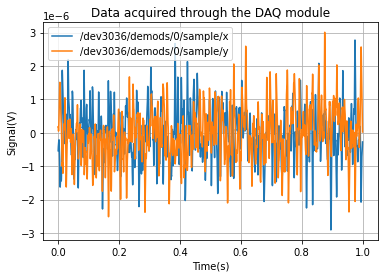

In [1]:
import matplotlib.pyplot as plt
import time

# Parameter
TOTAL_DURATION = 1  # [s]
SAMPLING_RATE = 30000  # Number of points/second
SAMPLE_NODES = [
    device.demods[0].sample.x,
    device.demods[0].sample.y,
]

# Configure the module
daq_module = session.modules.daq
daq_module.device(device)
daq_module.type(0)  # continuous acquisition
daq_module.grid.mode(2)
daq_module.count(1)
daq_module.duration(TOTAL_DURATION)
daq_module.grid.cols(SAMPLING_RATE)
for node in SAMPLE_NODES:
    daq_module.subscribe(node)

# start and wait for the module to finish
daq_module.execute()
while not daq_module.raw_module.finished():
    time.sleep(1)

# Read results and plot them
result = daq_module.read(raw=False, clk_rate=device.clockbase())
_, axis = plt.subplots(1, 1)
for sample_node in SAMPLE_NODES:
    axis.plot(
        result[sample_node][0].time,
        result[sample_node][0].value[0],
        label=sample_node
    )
axis.grid(True)
axis.legend()
axis.set_title("Data acquired through the DAQ module")
axis.set_xlabel("Time(s)")
axis.set_ylabel("Signal(V)")
plt.show()


## Upgrading QCoDeS and Labber drivers

Zurich Instruments supports the 3rd-party measurement frameworks QCoDeS and Labber with the drivers zhinst-qcodes and zhinst-labber, respectively, which are fully based on the zhinst-toolkit package. With the release of zhinst-zoolkit 0.3, we took the initiative to also upgrade our drivers for QCoDeS and Labber to take the advantage of the new features implemented in zhinst-toolkit.

The main benefits of the new QCoDeS and Labber drivers include:

* All nodes are available by the same name as in LabOne.
* All kinds of instruments and options are supported out of the box.
* Setup time overhead compared to ziPython is negligible.
* Full support for LabOne Modules (not all modules are supported in Labber yet).

Since the previous versions of drivers have a different structure and custom-named nodes, the transition to the new drivers requires an adaptation of existing user code. We are confident that it is worth the effort to migrate from the old versions to the latest release because of the substantial value the new features bring to the user. To minimize the effort, we are happy to support our customers during this small migration for which the users are encouraged to contact us via support@zhinst.com. The old version of drivers will continue to work but are not actively maintained. One can find the latest release of our [QCoDeS](https://github.com/zhinst/zhinst-qcodes) and [Labber](https://github.com/zhinst/zhinst-labber) drivers in GitHub.

## Conclusions

The zhinst-toolkit package, building on top of the familiar ziPython package, provides a high-level, user-friendly, and Pythonic API to the LabOne software. Together, they enable an efficient implementation of complex experiments involving instruments from multiple manufacturers and allow our users to automate sophisticated research experiments.